# Latent Diffusion Model for Protein Molecules

todo:
Explain the objective, and the motivation behind this
- Mainly touch on the point on equivariant, making use of the model's capabilities to learn rather than designing a complicated equivariant aware neural network for diffusion.

In [112]:
import dgl
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from dgl.data.utils import split_dataset
from dgl.data import QM9Dataset
import dgl.nn.pytorch as dglnn
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from dgl.nn import SAGEConv, AvgPooling, GraphConv
import matplotlib.pyplot as plt
import networkx as nx
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler
import numpy as np


## Load Data
As this is a simple attempt to evaluate capabilities of latent representation being used to train a diffusion model, we use the QM9Dataset from DGL for a start.

In [113]:
# even though the label_keys is given,
# we will not use the associated tensor as 
# we are not attempting a regression
qm9_data = QM9Dataset(label_keys=['mu'], cutoff=5.0)
print(len(qm9_data))
# Explore the data a little
for i in range(5):
    print(f"this is graph {i}")
    print(qm9_data[i])
    print("Node Data")
    print(qm9_data[i][0].ndata)    
    print("Edge Data") 
    print(qm9_data[i][0].edata)

130831
this is graph 0
(Graph(num_nodes=5, num_edges=20,
      ndata_schemes={'R': Scheme(shape=(3,), dtype=torch.float32), 'Z': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), tensor([0.]))
Node Data
{'R': tensor([[-1.2698e-02,  1.0858e+00,  8.0010e-03],
        [ 2.1504e-03, -6.0313e-03,  1.9761e-03],
        [ 1.0117e+00,  1.4638e+00,  2.7657e-04],
        [-5.4082e-01,  1.4475e+00, -8.7664e-01],
        [-5.2381e-01,  1.4379e+00,  9.0640e-01]]), 'Z': tensor([6, 1, 1, 1, 1])}
Edge Data
{}
this is graph 1
(Graph(num_nodes=4, num_edges=12,
      ndata_schemes={'R': Scheme(shape=(3,), dtype=torch.float32), 'Z': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), tensor([1.6256]))
Node Data
{'R': tensor([[-0.0404,  1.0241,  0.0626],
        [ 0.0173,  0.0125, -0.0274],
        [ 0.9158,  1.3587, -0.0288],
        [-0.5203,  1.3435, -0.7755]]), 'Z': tensor([7, 1, 1, 1])}
Edge Data
{}
this is graph 2
(Graph(num_nodes=3, num_edges=6,
      ndata_schemes={'R': Scheme

We can see that there are 130831 graphs within the dataset. Each graph has varying number of nodes (n). The nodes are atoms in the molecules. Each node has attributes of "R" and "Z". "R" represents the 3D coordinate (with dimension n x 3) and "Z" represents the atomic number of the atom. 

## Process Data
We will process the data so that only the relevant information are extracted and in the correct dimension for batch. 

In [114]:
def process_qm9_data(data):
    graphs, node_features, coordinates = [], [], []
    longest_len = 0
    for i in range(len(data)):
        num_nodes = len(data[i][0].ndata["Z"])
        g = dgl.graph(([], []), num_nodes=num_nodes)
        g.ndata['R'] = data[i][0].ndata["R"] # the 3D coordinates
        g = dgl.add_self_loop(g)
        
        # need to restructure the atomic number from 1 x n to n x 1
        # so that it's consistent dimensionality
        g.ndata['Z'] = data[i][0].ndata["Z"] # the atomic numbers
                
        graphs.append(g)
        
        # node_features.append(data[i][0].ndata["Z"].view(-1, 1))
        node_features.append(data[i][0].ndata["Z"])
        coordinates.append(data[i][0].ndata["R"])
        
        if longest_len < num_nodes:
            longest_len = num_nodes
        
    
    return graphs, longest_len, node_features, coordinates


In [115]:
graphs, longest_len, node_features, coordinates = process_qm9_data(qm9_data)

In [69]:
print(longest_len)


29


In [70]:
# check if the processing ok
print(graphs[0].ndata["R"])
print(graphs[0].ndata["Z"])
print(graphs[0].num_nodes())

tensor([[-1.2698e-02,  1.0858e+00,  8.0010e-03],
        [ 2.1504e-03, -6.0313e-03,  1.9761e-03],
        [ 1.0117e+00,  1.4638e+00,  2.7657e-04],
        [-5.4082e-01,  1.4475e+00, -8.7664e-01],
        [-5.2381e-01,  1.4379e+00,  9.0640e-01]])
tensor([6, 1, 1, 1, 1])
5


### Visualize the data a little

Number of nodes: 5
Number of edges: 0


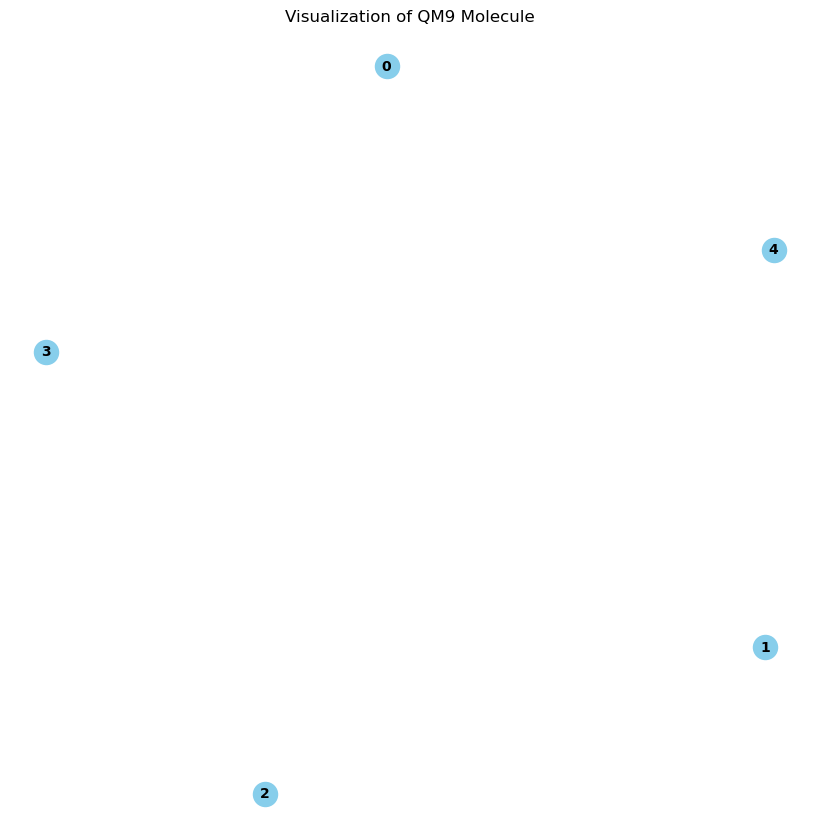

In [247]:
graph = graphs[0]
# Convert DGL graph to NetworkX graph
nx_graph = dgl.to_networkx(graph)

# You can inspect the nodes and edges
print(f"Number of nodes: {nx_graph.number_of_nodes()}")
print(f"Number of edges: {nx_graph.number_of_edges()}")

# Visualize the graph using NetworkX
plt.figure(figsize=(8, 8))

# Draw the graph using NetworkX
pos = nx.spring_layout(nx_graph, seed=42)  # Use a spring layout for node positioning
nx.draw(nx_graph, pos, with_labels=True, node_size=300, font_size=10, font_weight='bold', node_color='skyblue')

plt.title("Visualization of QM9 Molecule")
plt.show()

[6 1 1 1 1]


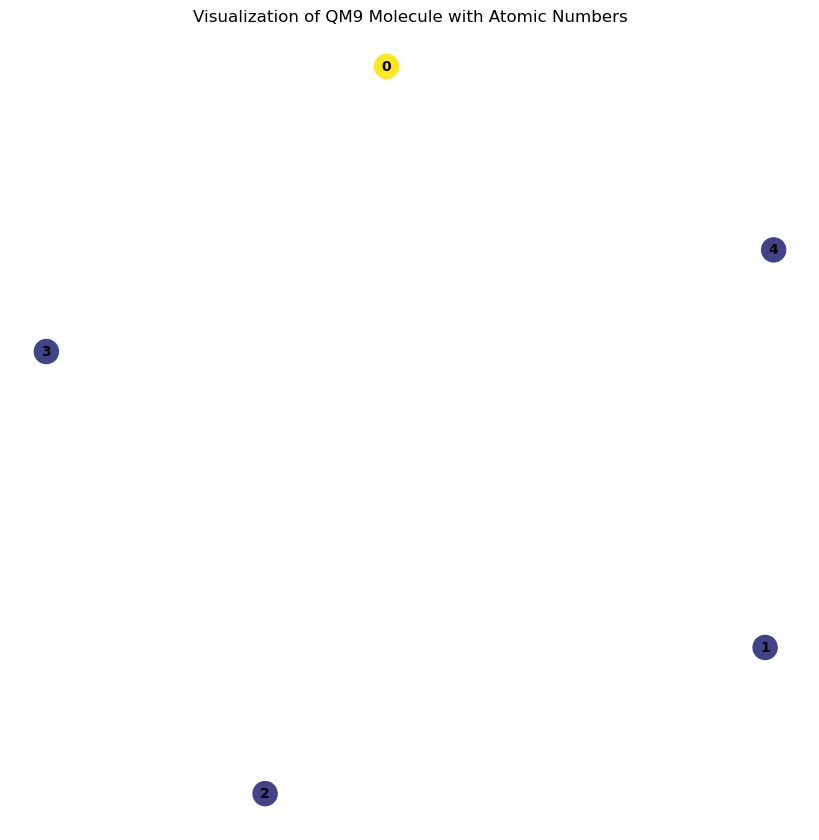

In [248]:
# Assuming node features contain atomic numbers in the 'h' attribute
atomic_numbers = node_features[0].numpy()  # Atomic numbers (first feature of 'h')
print(atomic_numbers)
# Map atomic numbers to colors (optional step)
node_colors = [plt.cm.viridis(atomic_number / 5) for atomic_number in atomic_numbers]

# Visualize the graph with customized node colors
plt.figure(figsize=(8, 8))
nx.draw(nx_graph, pos, with_labels=True, node_size=300, font_size=10, font_weight='bold', node_color=node_colors)
plt.title("Visualization of QM9 Molecule with Atomic Numbers")
plt.show()


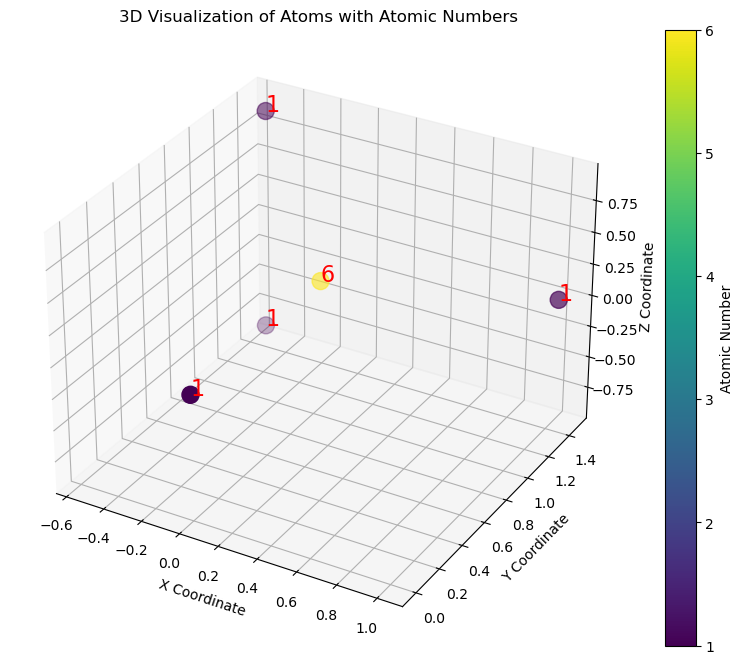

In [249]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Extract the x, y, and z coordinates
x = coordinates[0][:, 0]
y = coordinates[0][:, 1]
z = coordinates[0][:, 2]
scatter = ax.scatter(x, y, z, c=atomic_numbers, cmap='viridis', s=150)
# Add labels to atoms (optional)
for i in range(len(coordinates[0])):
    ax.text(x[i], y[i], z[i], f'{atomic_numbers[i]}', color='red', fontsize=16)

# Set labels for axes
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set the title of the plot
ax.set_title('3D Visualization of Atoms with Atomic Numbers')

# Show the plot
plt.colorbar(scatter, label='Atomic Number')  # Color bar indicating atomic number
plt.show()

## Create the Dataset

In [79]:
class GraphDataset(Dataset):
    def __init__(self, graphs, node_features, coordinates):
        self.graphs = graphs
        self.node_features = node_features
        self.coordinates = coordinates

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        coords = self.coordinates[idx].clone().detach()
        features = self.node_features[idx].clone().detach()
        return self.graphs[idx], features, coords

In [80]:
# Create the dataset
dataset = GraphDataset(graphs, node_features, coordinates)

Define the collate function for dataloader

In [81]:
def collate_fn(batch):
    """
    Collates a batch of graphs and their features into a batched graph.
    """
    graphs, features, coordinates = map(list, zip(*batch))
    batched_graph = dgl.batch(graphs)

    # Combine node features across the batch
    batch_categorical = torch.cat(features)
    batch_continuous = torch.cat(coordinates)

    return batched_graph, batch_categorical, batch_continuous

In [82]:
dataset_size = len(dataset)

# Define the split ratios
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [83]:
batch_size = 4  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## Latent Diffusion

In [84]:
class BatchedLatentDiffusionAutoencoder(nn.Module):
    def __init__(self, num_categories, embedding_dim, continuous_dim, latent_dim, diffusion_steps):
        super().__init__()
        
        # Embedding layer for categorical features
        self.embedding = nn.Embedding(num_categories, embedding_dim)
        
        # Graph convolutional encoder
        input_dim = embedding_dim + continuous_dim
        self.gcn_encoder = GraphConv(input_dim, latent_dim)
        
        # Diffusion process
        self.diffusion_steps = diffusion_steps
        self.noise_scheduler = self.get_noise_scheduler(diffusion_steps)
        self.denoising_model = GraphConv(latent_dim, latent_dim)
        
        # Graph convolutional decoder
        self.gcn_decoder = GraphConv(latent_dim, input_dim)
        
        # Output heads for reconstruction
        self.cat_decoder = nn.Linear(embedding_dim, num_categories)  # Categorical reconstruction
        self.cont_decoder = nn.Linear(continuous_dim, continuous_dim)  # Continuous reconstruction

    def get_noise_scheduler(self, steps):
        # Linear noise schedule for simplicity
        return torch.linspace(0.01, 0.1, steps)

    def forward(self, g, categorical, continuous, t):
        # Node embeddings for categorical features
        cat_embedded = self.embedding(categorical)
        
        # Concatenate embeddings with continuous features
        node_features = torch.cat([cat_embedded, continuous], dim=-1)
        
        # Encode node features into latent space
        latent = self.gcn_encoder(g, node_features)
        
        # Diffusion process
        noise_level = self.noise_scheduler[t]
        noise = torch.randn_like(latent) * noise_level
        noisy_latent = latent + noise
        
        # Denoise latent space
        denoised_latent = self.denoising_model(g, noisy_latent)
        
        # Decode to original feature space
        decoded = self.gcn_decoder(g, denoised_latent)
        
        # Split decoded output
        decoded_cat = self.cat_decoder(decoded[:, :cat_embedded.size(-1)])
        decoded_cont = self.cont_decoder(decoded[:, cat_embedded.size(-1):])
        
        return decoded_cat, decoded_cont, latent, denoised_latent

### Loss function
Since there are 2 types of data, we will do 2 different loss calculation. 

In [85]:
# Loss functions
def diffusion_loss(latent, denoised_latent, noise):
    return F.mse_loss(denoised_latent, latent - noise)

def reconstruction_loss(original_cat, reconstructed_cat, original_cont, reconstructed_cont):
    # Categorical loss
    cat_loss = nn.CrossEntropyLoss()(reconstructed_cat, original_cat)
    
    # Continuous loss
    cont_loss = nn.MSELoss()(reconstructed_cont, original_cont)
    
    # Combine losses
    return cat_loss + cont_loss

## Training

In [96]:
# Hyperparameters
num_categories = 10  # Number of unique categories
embedding_dim = 3   # Embedding size for categorical data
continuous_dim = 3  # Dimensionality of continuous features
latent_dim = 16     # Latent space size

In [87]:
# Initialize the model
diffusion_steps = 10
model = BatchedLatentDiffusionAutoencoder(num_categories=10, embedding_dim=3, continuous_dim=3, latent_dim=16, diffusion_steps=diffusion_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(50):
    epoch_loss = 0
    
    for batched_graph, batch_categorical, batch_continuous in train_loader:
        # Randomly sample a diffusion step
        t = torch.randint(0, diffusion_steps, (1,)).item()
        
        # Forward pass
        reconstructed_cat, reconstructed_cont, latent, denoised_latent = model(
            batched_graph, batch_categorical, batch_continuous, t
        )
        
        # Compute losses
        noise = torch.randn_like(latent) * model.noise_scheduler[t]
        diffusion_loss = F.mse_loss(denoised_latent, latent - noise)
        reconstruction_loss = (
            nn.CrossEntropyLoss()(reconstructed_cat, batch_categorical) +
            nn.MSELoss()(reconstructed_cont, batch_continuous)
        )
        
        # Combine losses
        loss = diffusion_loss + reconstruction_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1470.4748
Epoch 2, Loss: 161.7503
Epoch 3, Loss: 159.1344
Epoch 4, Loss: 153.5720
Epoch 5, Loss: 164.3789
Epoch 6, Loss: 155.5456
Epoch 7, Loss: 156.6519
Epoch 8, Loss: 160.8115
Epoch 9, Loss: 162.2933
Epoch 10, Loss: 154.5567
Epoch 11, Loss: 152.0670
Epoch 12, Loss: 156.2635
Epoch 13, Loss: 153.9749
Epoch 14, Loss: 145.7795
Epoch 15, Loss: 156.1852
Epoch 16, Loss: 157.8254
Epoch 17, Loss: 147.1590
Epoch 18, Loss: 154.0227
Epoch 19, Loss: 166.7597
Epoch 20, Loss: 160.0313
Epoch 21, Loss: 153.2704
Epoch 22, Loss: 149.1131
Epoch 23, Loss: 153.7024
Epoch 24, Loss: 154.1729
Epoch 25, Loss: 146.6671
Epoch 26, Loss: 155.5894
Epoch 27, Loss: 154.5165
Epoch 28, Loss: 163.5011
Epoch 29, Loss: 153.7382
Epoch 30, Loss: 155.3717
Epoch 31, Loss: 148.0394
Epoch 32, Loss: 156.6881
Epoch 33, Loss: 159.0890
Epoch 34, Loss: 155.4514
Epoch 35, Loss: 148.6526
Epoch 36, Loss: 169.0434
Epoch 37, Loss: 141.9597
Epoch 38, Loss: 147.2364
Epoch 39, Loss: 150.7829
Epoch 40, Loss: 157.2775
Epoch 41

# Generate data

In [99]:


def reverse_diffusion(model, g, num_nodes, diffusion_steps, embedding_dim, continuous_dim, latent_dim):
    # Initialize random noise (latents) for generation
    noise_level = model.noise_scheduler[diffusion_steps - 1]  # Start with the highest noise level
    in_feats = embedding_dim + continuous_dim
    latent = torch.randn(num_nodes, latent_dim).to(g.device)  # Random noise in latent space

    # Reverse the diffusion process (denoising step)
    for t in reversed(range(diffusion_steps)):
        # Denoise the latent using the trained model
        denoised_latent = model.denoising_model(g, latent)
        
        # Apply the noise scheduler at timestep t
        noise_level = model.noise_scheduler[t]
        latent = (latent - noise_level * denoised_latent) / torch.sqrt(1 - noise_level**2)
        
    # Decode the latent to original feature space
    decoded = model.gcn_decoder(g, latent)
    
    # Split decoded output into categorical and continuous
    decoded_cat = model.cat_decoder(decoded[:, :model.embedding.embedding_dim])
    decoded_cont = model.cont_decoder(decoded[:, model.embedding.embedding_dim:])
    
    # Convert categorical values to the most likely class (argmax)
    cat_output = torch.argmax(F.softmax(decoded_cat, dim=-1), dim=-1)
    
    # Return generated categorical and continuous data
    return cat_output, decoded_cont



In [108]:
generated_graphs = []
for batched_graph, batch_categorical, batch_continuous in val_loader:
    individual_graphs = dgl.unbatch(batched_graph)
    # Check the unbatched graphs
    for i, g in enumerate(individual_graphs):
    
        num_nodes = g.num_nodes()
        generated_cat, generated_cont = reverse_diffusion(model, g, num_nodes, diffusion_steps=model.diffusion_steps, embedding_dim=embedding_dim, continuous_dim=continuous_dim, latent_dim=latent_dim)

        # `generated_cat` contains the atomic numbers, `generated_cont` contains 3D coordinates
        generated_g = dgl.graph(([], []), num_nodes=num_nodes)
        generated_g.ndata["R"] = generated_cont
        generated_g.ndata["Z"] = generated_cat
        
        generated_graphs.append(generated_g)
    
    

## Visualize one of the generated molecule

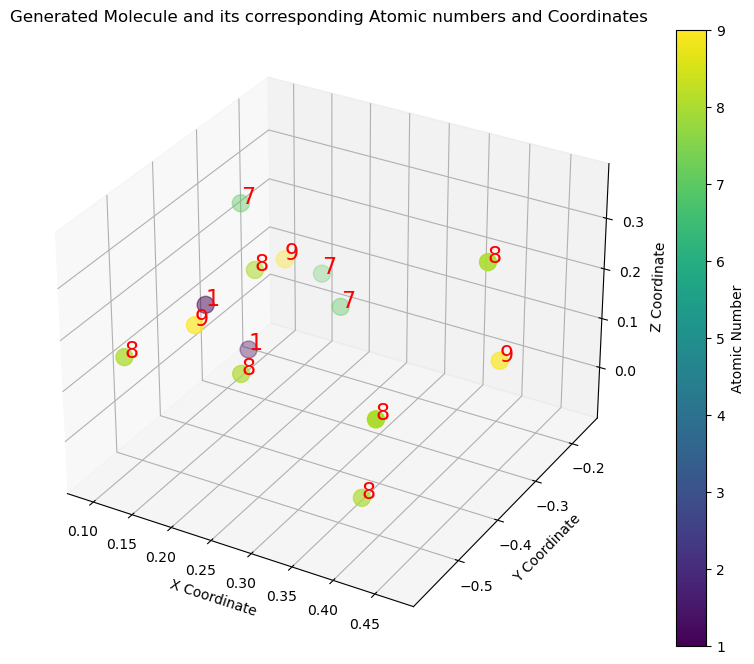

In [111]:

generated_coords = generated_graphs[0].ndata["R"].detach().numpy()
generated_atom = generated_graphs[0].ndata["Z"].detach().numpy()
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Extract the x, y, and z coordinates
x = generated_coords[:, 0]
y = generated_coords[:, 1]
z = generated_coords[:, 2]
scatter = ax.scatter(x, y, z, c=generated_atom, cmap='viridis', s=150)
ax.plot(x, y, z, color="black")
# Add labels to atoms (optional)
for i in range(len(generated_atom)):
    ax.text(x[i], y[i], z[i], f'{generated_atom[i]}', color='red', fontsize=16)

# Set labels for axes
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set the title of the plot
ax.set_title('Generated Molecule and its corresponding Atomic numbers and Coordinates')

# Show the plot
plt.colorbar(scatter, label='Atomic Number')  # Color bar indicating atomic number
plt.show()